In [1]:
import os
os.chdir('..')


In [2]:

import nmrglue as ng
import numpy as np
from cops_analysis import cops_analyze
from cops_prediction import gaussian
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
%%time
a = cops_analyze(['./SHP2_Gradcops/SHP2_Grad1.ft3',
                  './SHP2_Gradcops/SHP2_Grad3.ft3',
                  './SHP2_Gradcops/SHP2_Grad5.ft3',
                  './SHP2_Gradcops/SHP2_Grad6.ft3'],
                 mode='HNCA', cop_num=[1,2,4,5], pyruvate_on=False)
                 

CPU times: user 10.4 s, sys: 7.23 s, total: 17.6 s
Wall time: 17.6 s


In [28]:
#removed index 342: CA way too low!

tb = pd.read_csv('./dev/SHP2_processed.csv', sep='\t')
tb = tb.rename(columns={'w1':'HN','w2':'CA','w3':'N'})
tb = tb.drop([342])
tb.reindex()

#realign spectra
shifts_array = tb[['CA', 'N','HN']].to_numpy(dtype=np.float32)
shifts_array[:,[0,1]]=shifts_array[:,[1,0]]

In [29]:
shifts_array = np.around(shifts_array, 2)

[119.77  53.96   6.17]


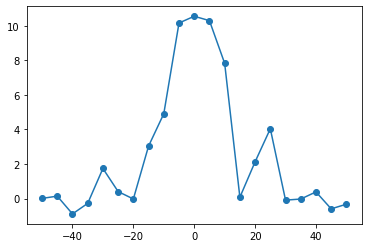

In [30]:
data = shifts_array[342] #18 for K27, #-4 for K49
print(data)
hz, nocop_trace = a.extract1D(data, a.cop_dats[1], a.cop_unit_convs[1], sw=50, C_offset=0, normalize=True)
plt.plot(hz, nocop_trace, '-o')

[19.68477322  1.         23.8009957   0.40620029 20.28460326  7.21708155]
0.0019099142995695638


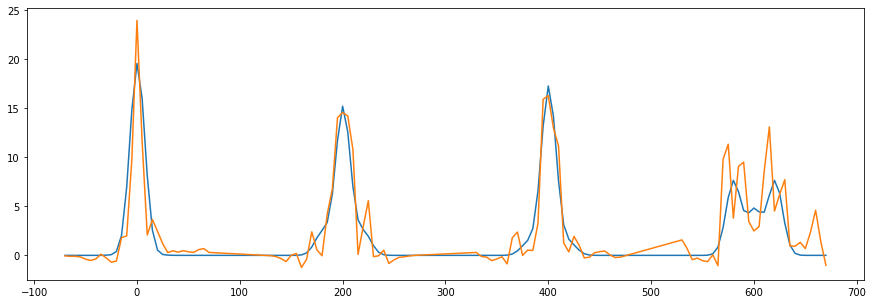

In [31]:
params,error = a.CalcCB(data, simple_output=False, sw=70)

hz, _ = a.extract1D(data, a.cop_dats[1], a.cop_unit_convs[1], sw=70, normalize=True)
cop_1Ds = np.array([a.extract1D(data, a.cop_dats[i], a.cop_unit_convs[i], sw=70, normalize=True)[1] for i in range(a.cop_num)])
cop_1Ds = cop_1Ds.reshape(-1)
print(params)
print(error)
hz_long = np.array([hz+200*i for i in range(a.cop_num)]).reshape(-1)
plt.figure(figsize=(15,5))
plt.plot(hz_long, a.lineshape_Cb(hz, *params), hz_long, cop_1Ds)

In [44]:
for j in range(len(shifts_array)):
    slice_1D= np.array([a.extract1D(shifts_array[j], a.cop_dats[i], a.cop_unit_convs[i],sw=40, normalize=True)[1] 
                                 for i in range(a.cop_num)]).reshape(-1)
    if j == 0:
        dslice_cop = ([slice_1D])
    else:
        dslice_cop = dslice_cop+[slice_1D]
        
dslice_cop = np.vstack(dslice_cop)    
dslice_cop.shape

array([-0.08125452,  1.67556052,  2.24391815,  5.28248694,  6.31996452,
        4.70233102,  4.56436579,  4.40460572,  4.34499605,  4.45916617,
        6.00402977,  6.46859899,  4.6011025 ,  2.62659379,  2.17678167,
        1.21892325, -0.10300984,  2.89282022,  1.16396771,  0.761666  ,
        4.97738065,  6.57783773,  5.00825472,  3.34701279,  3.29158311,
        2.70197249,  2.14884532,  6.1727494 ,  7.4278102 ,  5.61251249,
        4.64593112,  1.55641631,  1.00752656,  1.3486414 ,  0.35607432,
        0.53866047, -0.26547842,  0.02669102,  2.79433085,  4.16073754,
        4.63870531,  9.21498054, 10.55364292,  5.04807079,  3.06871642,
        3.08934066,  1.00927791, -0.15146542,  0.19388645,  0.22788031,
       -0.06197534,  1.38740726,  0.7047868 ,  0.06862786,  0.40027563,
        0.77057129,  5.21367451, 10.28337053,  7.54789008,  6.75995762,
        3.79020494,  1.54137191,  4.86857636,  2.52697407,  0.54573662,
        1.68963576,  0.44500202, -0.20259418])

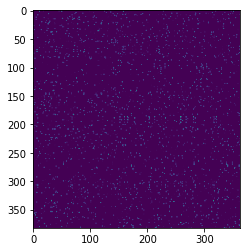

In [42]:
CAs = tb['CA'].to_numpy()
CAs_seq = CAs[tb['is_sequential']]
CAs_int = CAs[~tb['is_sequential']]
CA_diff = CAs_seq.reshape(1, -1) - CAs_int.reshape(-1,1)
CAs_likelihood = gaussian(CA_diff, 0,0.05)
plt.imshow(CAs_likelihood)

In [12]:
from sklearn.cluster import SpectralBiclustering

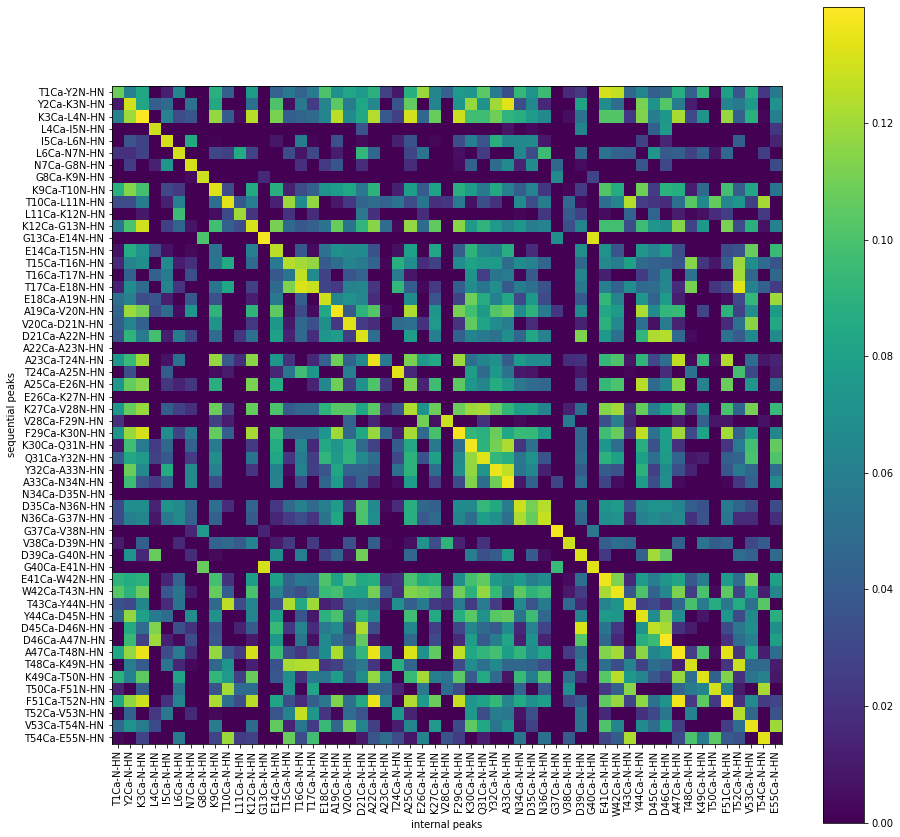

In [13]:
threshold=0.85#atm 0.92
data = np.append(dslice_nocop, dslice_cop, axis=1)
data_sequential = data[tb['is_sequential']]
data_internal = data[~tb['is_sequential']]
T = np.corrcoef(data_internal, data_sequential)[len(data_internal):,0:len(data_internal)]
T[T<threshold] = threshold
T=T-threshold
plt.figure(figsize=[15,15])
plt.imshow(T)
plt.xticks(np.arange(55), tb[~tb['is_sequential']]['Assignment'], rotation='vertical')
plt.xlabel('internal peaks')
plt.yticks(np.arange(54), tb[tb['is_sequential']]['Assignment'], rotation='horizontal')
plt.ylabel('sequential peaks')
plt.colorbar()
plt.show()

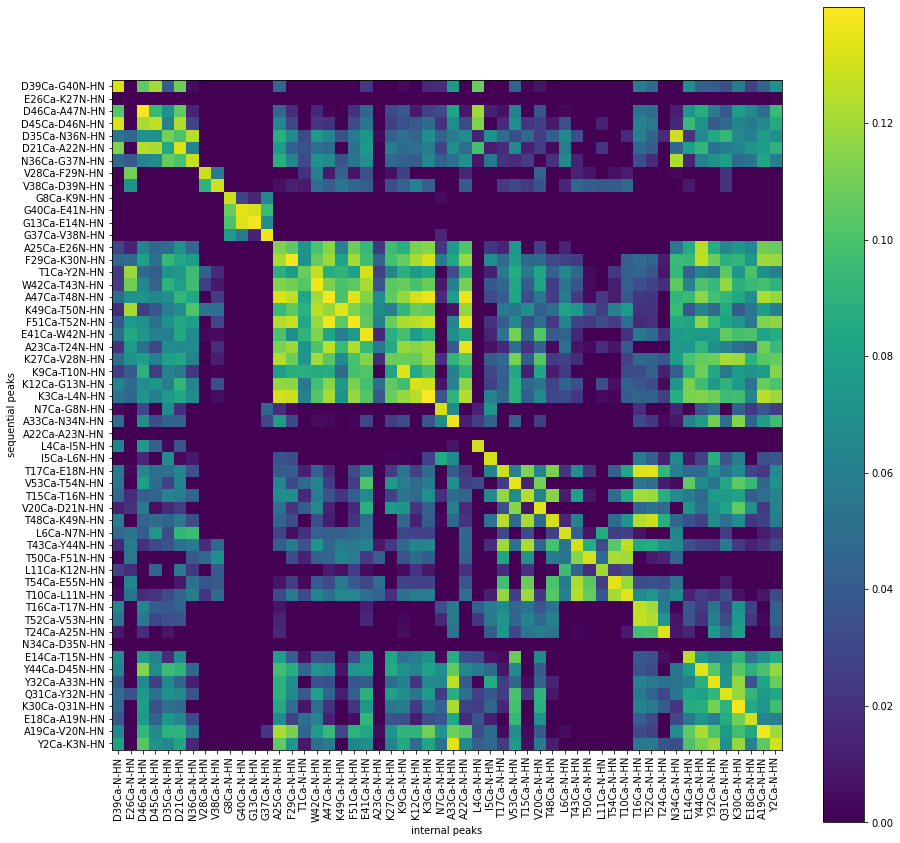

In [14]:
model = SpectralBiclustering(n_clusters=10)
T = np.corrcoef(data_internal, data_sequential)[len(data_internal):,0:len(data_internal)]
model.fit(T+0.0001)

fit_T = T[np.argsort(model.row_labels_)]
fit_T = fit_T[:,np.argsort(model.row_labels_)]
fit_T[fit_T<threshold] = threshold
fit_T=fit_T-threshold

plt.figure(figsize=[15,15])
plt.imshow(fit_T)

internal_labels = tb[~tb['is_sequential']]['Assignment']
sequential_labels = tb[tb['is_sequential']]['Assignment']

plt.xticks(np.arange(54), internal_labels.to_numpy()[np.argsort(model.row_labels_)], rotation='vertical')
plt.xlabel('internal peaks')
plt.yticks(np.arange(54), sequential_labels.to_numpy()[np.argsort(model.row_labels_)], rotation='horizontal')
plt.ylabel('sequential peaks')
plt.colorbar()
plt.show()

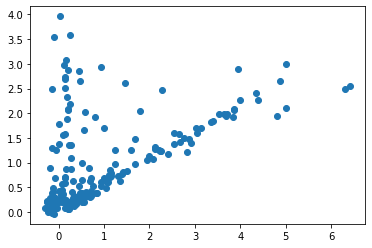

In [164]:
plt.scatter(data_internal[50], data_sequential[50])

[54.169 10.333]


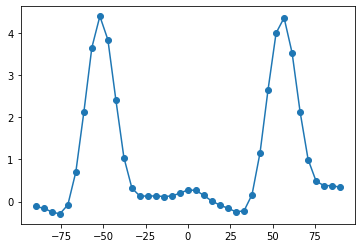

In [166]:
data = shifts_array[100] #18 for K27, #-4 for K49
print(shifts_array[100])
hz, nocop_trace = b.extract1D(data, b.cop_dats[0], b.cop_unit_convs[0], sw=90, C_offset=-0.09, normalize=True)
plt.plot(hz, nocop_trace, '-o')

In [280]:
#clustering groups: 5 for pyruvate, 10 for pyruvate-cops, ?? for cops. this is stochastic